In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import scipy.stats as ss

In [2]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

In [3]:
summary = pd.read_csv('data/summary.csv')

In [4]:
summary.head()

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,pain,patient,priority,temperature
0,1830,22,113,53,593,137,24,456,no pain,1831,normal,36.7
1,4220,22,113,49,749,193,49,556,no pain,4220,normal,36.8
2,822,8,131,39,1106,169,12,937,moderate pain,820,urgent,37.3
3,386,20,138,55,574,164,6,410,no pain,387,normal,36.7
4,4321,52,161,89,999,208,50,790,moderate pain,4322,urgent,37.1


In [5]:
summary['temp_cat'] = pd.cut(summary['temperature'],
                             bins=[float('-inf'), 36.5, 37.5, float('inf')],
                             labels=['hypothermia', 'normal', 'fever'])

summary['patient'] -= 1

In [6]:
summary.drop(['Unnamed: 0', 'arrival_time', 'assessment_start_time', 'duration', 'patient'],
             axis=1, inplace=True)
summary.sort_values(['day', 'assessment_end_time'], inplace=True)
summary.reset_index(drop=True, inplace=True)

In [7]:
summary.head()

,assessment_end_time,consultation_end_time,consultation_start_time,day,pain,priority,temperature,temp_cat
0,741,1620,773,1,no pain,urgent,36.6,normal
1,851,1881,905,1,severe pain,normal,36.7,normal
2,1055,1595,1084,1,severe pain,normal,36.8,normal
3,1244,2105,1294,1,severe pain,urgent,36.6,normal
4,1351,3322,1378,1,severe pain,urgent,36.2,hypothermia


In [8]:
df = summary[summary['day'] == 1].reset_index(drop=True)
df

,assessment_end_time,consultation_end_time,consultation_start_time,day,pain,priority,temperature,temp_cat
0,741,1620,773,1,no pain,urgent,36.6,normal
1,851,1881,905,1,severe pain,normal,36.7,normal
2,1055,1595,1084,1,severe pain,normal,36.8,normal
3,1244,2105,1294,1,severe pain,urgent,36.6,normal
4,1351,3322,1378,1,severe pain,urgent,36.2,hypothermia
5,1923,3141,1946,1,moderate pain,normal,36.4,hypothermia
6,2042,2763,2065,1,no pain,urgent,37.2,normal
7,2248,2717,2289,1,no pain,normal,36.7,normal
8,2405,3083,2434,1,moderate pain,normal,36.6,normal
9,2502,2791,2524,1,moderate pain,normal,36.8,normal


In [9]:
df.shape

(76, 8)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   assessment_end_time      76 non-null     int64   
 1   consultation_end_time    76 non-null     int64   
 2   consultation_start_time  76 non-null     int64   
 3   day                      76 non-null     int64   
 4   pain                     76 non-null     object  
 5   priority                 76 non-null     object  
 6   temperature              76 non-null     float64 
 7   temp_cat                 76 non-null     category
dtypes: category(1), float64(1), int64(4), object(2)
memory usage: 4.5+ KB


In [11]:
def create_new_features(df):
    free_docs = [6]
    q_urg = [list()]
    q_norm = [list()]
    q_real = [list()]
    urgs_on_q = [0]
    q_size = 0
    nonbusy_docs = 0
    consult_endtime_ls = [df.loc[0, 'consultation_end_time']]
    
    for i in range(1, len(df)):
        nonbusy_docs = (df.loc[i, 'assessment_end_time'] >= consult_endtime_ls).sum()
        consult_endtime_ls = consult_endtime_ls[nonbusy_docs:]

        if free_docs[i - 1] > 1:
            free_docs.append(free_docs[i - 1] - 1 + nonbusy_docs)
            consult_endtime_ls.append(df.loc[i, 'consultation_end_time'])
            consult_endtime_ls = sorted(consult_endtime_ls)
            q_urg.append(q_urg[i - 1])
            q_norm.append(q_norm[i - 1])
            q_real.append(q_urg[i] + q_norm[i])
            urgs_on_q.append(urgs_on_q[i - 1])
        elif nonbusy_docs == 0:
            free_docs.append(0)
            if df.loc[i, 'priority'] == 'urgent':
                urgs_on_q.append(urgs_on_q[i - 1] + 1)
                q_urg.append(q_urg[i - 1] + [i])
                q_norm.append(q_norm[i - 1])
            else:
                urgs_on_q.append(urgs_on_q[i - 1])
                q_urg.append(q_urg[i - 1])
                q_norm.append(q_norm[i - 1] + [i])
            q_real.append(q_urg[i] + q_norm[i])
            q_size = len(q_real[i])
        elif q_size == 0:
            free_docs.append(free_docs[i - 1] - 1 + nonbusy_docs)
            q_urg.append(q_urg[i - 1])
            q_norm.append(q_norm[i - 1])
            q_real.append(q_urg[i] + q_norm[i])
            urgs_on_q.append(urgs_on_q[i - 1])
            consult_endtime_ls.append(df.loc[i, 'consultation_end_time'])
            consult_endtime_ls = sorted(consult_endtime_ls)
        else:
            free_docs.append(np.max([free_docs[i - 1] + nonbusy_docs - q_size, 0]))
            if df.loc[i, 'priority'] == 'urgent':
                urgs_on_q.append(urgs_on_q[i - 1] + 1)
                q_urg.append(q_urg[i - 1] + [i])
                q_norm.append(q_norm[i - 1])
            else:
                urgs_on_q.append(urgs_on_q[i - 1])
                q_urg.append(q_urg[i - 1])
                q_norm.append(q_norm[i - 1] + [i])
            q_real.append(q_urg[i] + q_norm[i])
            q_size = len(q_real[i])
            while q_size > 0 and nonbusy_docs > 0:
                patient = q_real[i].pop(0)
                if df.loc[patient, 'priority'] == 'urgent':
                    urgs_on_q[i] -= 1
                    q_urg[i].pop(0)
                else:
                    q_norm[i].pop(0)
                consult_endtime_ls.append(df.loc[patient, 'consultation_end_time'])
                consult_endtime_ls = sorted(consult_endtime_ls)
                q_size -= 1
                nonbusy_docs -= 1
                
    df_features = pd.DataFrame([free_docs, pd.Series(q_real).apply(lambda x: len(x)), urgs_on_q],
                                index=['free_doctors', 'queue_size', 'urgents_on_queue']).T
    
    return pd.concat([df, df_features], axis=1)

In [12]:
summary_new = pd.DataFrame(columns=summary.columns)
for i in range(50):
    df_new = create_new_features(summary[summary['day'] == i + 1].reset_index(drop=True))
    summary_new = pd.concat([summary_new, df_new], axis=0)

summary_new.reset_index(drop=True, inplace=True)

In [13]:
summary_new.head()

,assessment_end_time,consultation_end_time,consultation_start_time,day,pain,priority,temperature,temp_cat,free_doctors,queue_size,urgents_on_queue
0,741,1620,773,1,no pain,urgent,36.6,normal,6.0,0.0,0.0
1,851,1881,905,1,severe pain,normal,36.7,normal,5.0,0.0,0.0
2,1055,1595,1084,1,severe pain,normal,36.8,normal,4.0,0.0,0.0
3,1244,2105,1294,1,severe pain,urgent,36.6,normal,3.0,0.0,0.0
4,1351,3322,1378,1,severe pain,urgent,36.2,hypothermia,2.0,0.0,0.0


In [14]:
# sns.pairplot(summary);

In [15]:
# sns.pairplot(day1);

In [16]:
# print(summary.shape)
# print(len(summary['Unnamed: 0'].unique()))
# print(len(summary['patient'].unique()))

In [17]:
# summary.head(20)

In [18]:
df_train = summary_new[summary_new['day'] == 1]
# df_train.loc[[63, 64]]
df_train

,assessment_end_time,consultation_end_time,consultation_start_time,day,pain,priority,temperature,temp_cat,free_doctors,queue_size,urgents_on_queue
0,741,1620,773,1,no pain,urgent,36.6,normal,6.0,0.0,0.0
1,851,1881,905,1,severe pain,normal,36.7,normal,5.0,0.0,0.0
2,1055,1595,1084,1,severe pain,normal,36.8,normal,4.0,0.0,0.0
3,1244,2105,1294,1,severe pain,urgent,36.6,normal,3.0,0.0,0.0
4,1351,3322,1378,1,severe pain,urgent,36.2,hypothermia,2.0,0.0,0.0
5,1923,3141,1946,1,moderate pain,normal,36.4,hypothermia,4.0,0.0,0.0
6,2042,2763,2065,1,no pain,urgent,37.2,normal,3.0,0.0,0.0
7,2248,2717,2289,1,no pain,normal,36.7,normal,3.0,0.0,0.0
8,2405,3083,2434,1,moderate pain,normal,36.6,normal,2.0,0.0,0.0
9,2502,2791,2524,1,moderate pain,normal,36.8,normal,1.0,0.0,0.0


In [19]:
# sns.scatterplot('patient', 'arrival_time', data=summary, hue='day');

In [20]:
# summary.loc[summary['day'] == 50, 'arrival_time'].corr(summary.loc[summary['day'] == 50, 'patient'])

In [21]:
# df = summary.sort_values(['day', 'arrival_time'])

In [22]:
# summary_new.head()

In [23]:
summary_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   assessment_end_time      4420 non-null   object 
 1   consultation_end_time    4420 non-null   object 
 2   consultation_start_time  4420 non-null   object 
 3   day                      4420 non-null   object 
 4   pain                     4420 non-null   object 
 5   priority                 4420 non-null   object 
 6   temperature              4420 non-null   float64
 7   temp_cat                 4420 non-null   object 
 8   free_doctors             4420 non-null   float64
 9   queue_size               4420 non-null   float64
 10  urgents_on_queue         4420 non-null   float64
dtypes: float64(4), object(7)
memory usage: 380.0+ KB


In [24]:
df = summary_new.apply(lambda col: pd.to_numeric(col, errors='ignore'), axis=1)

In [25]:
df['duration'] = df['consultation_end_time'] - df['consultation_start_time']
df.drop('consultation_end_time', axis=1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   assessment_end_time      4420 non-null   int64  
 1   consultation_start_time  4420 non-null   int64  
 2   day                      4420 non-null   int64  
 3   pain                     4420 non-null   object 
 4   priority                 4420 non-null   object 
 5   temperature              4420 non-null   float64
 6   temp_cat                 4420 non-null   object 
 7   free_doctors             4420 non-null   float64
 8   queue_size               4420 non-null   float64
 9   urgents_on_queue         4420 non-null   float64
 10  duration                 4420 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 380.0+ KB


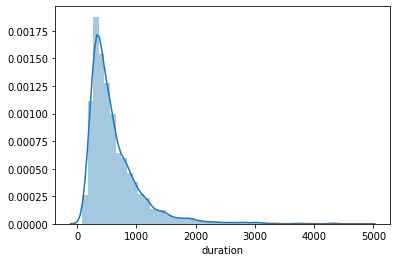

In [27]:
sns.distplot(df['duration']);

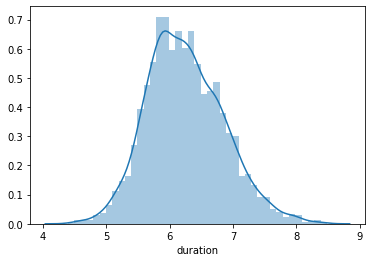

In [28]:
sns.distplot(np.log(df['duration']));
df['log_consult_duration'] = np.log(df['duration'])

In [29]:
df['temperature'].describe()

count    4420.000000
mean       36.872330
std         0.452982
min        35.900000
25%        36.700000
50%        36.800000
75%        36.925000
max        42.600000
Name: temperature, dtype: float64

In [30]:
df = pd.get_dummies(df, columns=['pain', 'temp_cat'])

In [31]:
df

,assessment_end_time,consultation_start_time,day,priority,temperature,free_doctors,queue_size,urgents_on_queue,duration,log_consult_duration,pain_moderate pain,pain_no pain,pain_severe pain,temp_cat_fever,temp_cat_hypothermia,temp_cat_normal
0,741,773,1,urgent,36.6,6.0,0.0,0.0,847,6.741701,0,1,0,0,0,1
1,851,905,1,normal,36.7,5.0,0.0,0.0,976,6.883463,0,0,1,0,0,1
2,1055,1084,1,normal,36.8,4.0,0.0,0.0,511,6.236370,0,0,1,0,0,1
3,1244,1294,1,urgent,36.6,3.0,0.0,0.0,811,6.698268,0,0,1,0,0,1
4,1351,1378,1,urgent,36.2,2.0,0.0,0.0,1944,7.572503,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4415,15368,15398,50,urgent,35.9,3.0,0.0,0.0,2669,7.889459,0,0,1,0,1,0
4416,15547,15584,50,normal,36.8,5.0,0.0,0.0,266,5.583496,0,1,0,0,0,1
4417,15680,15703,50,normal,36.5,4.0,0.0,0.0,601,6.398595,0,0,1,0,1,0
4418,15829,15856,50,normal,36.9,3.0,0.0,0.0,306,5.723585,0,1,0,0,0,1


In [32]:
df['pain_no pain:temp_cat_hypothermia'] = df['pain_no pain'] * df['temp_cat_hypothermia']
df['pain_moderate pain:temp_cat_hypothermia'] = df['pain_moderate pain'] * df['temp_cat_hypothermia']
df['pain_severe pain:temp_cat_hypothermia'] =df['pain_severe pain'] * df['temp_cat_hypothermia']

df['pain_no pain:temp_cat_normal'] = df['pain_no pain'] * df['temp_cat_normal']
df['pain_moderate pain:temp_cat_normal'] = df['pain_moderate pain'] * df['temp_cat_normal']
df['pain_severe pain:temp_cat_normal'] = df['pain_severe pain'] * df['temp_cat_normal']

df['pain_no pain:temp_cat_fever'] = df['pain_no pain'] * df['temp_cat_fever']
df['pain_moderate pain:temp_cat_fever'] = df['pain_moderate pain'] * df['temp_cat_fever']
df['pain_severe pain:temp_cat_fever'] = df['pain_severe pain'] * df['temp_cat_fever']

df.drop(['pain_no pain', 'pain_moderate pain', 'pain_severe pain',
         'temp_cat_hypothermia', 'temp_cat_normal', 'temp_cat_fever',
         'temperature'], axis=1, inplace=True)

In [33]:
priority_map = {'normal': 1, 'urgent': 2}
df['priority_enc'] = df['priority'].map(priority_map)

In [34]:
cols_to_drop = ['duration', 'priority']
df.drop(cols_to_drop, axis=1, inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   assessment_end_time                      4420 non-null   int64  
 1   consultation_start_time                  4420 non-null   int64  
 2   day                                      4420 non-null   int64  
 3   free_doctors                             4420 non-null   float64
 4   queue_size                               4420 non-null   float64
 5   urgents_on_queue                         4420 non-null   float64
 6   log_consult_duration                     4420 non-null   float64
 7   pain_no pain:temp_cat_hypothermia        4420 non-null   uint8  
 8   pain_moderate pain:temp_cat_hypothermia  4420 non-null   uint8  
 9   pain_severe pain:temp_cat_hypothermia    4420 non-null   uint8  
 10  pain_no pain:temp_cat_normal             4420 no

In [36]:
X_train = df[df['day'] <= 45].drop(['day', 'log_consult_duration'], axis=1)
X_test = df[df['day'] > 45].drop(['day', 'log_consult_duration'], axis=1)
y_train = df.loc[df['day'] <= 45, 'log_consult_duration']
y_test = df.loc[df['day'] > 45, 'log_consult_duration']

In [37]:
tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge(normalize=True, random_state=42)

ridge_params = {'alpha': ss.uniform(0, 1)}

rscv = RandomizedSearchCV(ridge,
                          ridge_params,
                          scoring='neg_root_mean_squared_error',
                          n_jobs=-1,
                          cv=tscv,
                          verbose=1,
                          random_state=42,
                          return_train_score=True)

rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=True,
                                   random_state=42, solver='auto', tol=0.001),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8bcfbc2350>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=1)

In [38]:
lm = rscv.best_estimator_
lm

Ridge(alpha=0.05808361216819946, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=42, solver='auto', tol=0.001)

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
cv_results = pd.DataFrame(rscv.cv_results_)
train_rmse = -cv_results.loc[rscv.best_index_, 'mean_train_score']
val_rmse = -cv_results.loc[rscv.best_index_, 'mean_test_score']

test_rmse = mean_squared_error(y_test, lm.predict(X_test_scaled), squared=False)

print(f'train rmse: {train_rmse}')
print(f'val rmse: {val_rmse}')
print(f'test rmse: {test_rmse}')

train rmse: 0.4134807304849365
val rmse: 0.45746067063411494
test rmse: 1.206560164907778
